### Session Creation

In [27]:
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col
import configparser


# Loading Credentials From Config File
snowflake_credentials_file = '../snowflake_creds.config'
config = configparser.ConfigParser()
config.read(snowflake_credentials_file)
connection_parameters = dict(config['default'])
session = Session.builder.configs(connection_parameters).create()

##### Reading BSD_TRAINING Table
* BSD_TRAINING table is loaded in chaptee 5
* Refer chapter_5.ipynb to create BSD_TRAINING table

In [28]:
FEATURE_LIST = [ "HOLIDAY", "WORKINGDAY", "HUMIDITY", "TEMP", "ATEMP", "WINDSPEED", "SEASON", "WEATHER"]
LABEL_COLUMNS = ['COUNT']
OUTPUT_COLUMNS = ['PREDICTED_COUNT']

df = session.table("BSD_TRAINING")
df = df.drop("DATETIME","DATE")
df.show(2)

-------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"  |"CASUAL"  |"REGISTERED"  |"COUNT"  |
-------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |81          |0.0          |3         |13            |16       |
|1         |0          |0             |1          |9.02    |13.635   |80          |0.0          |8         |32            |40       |
-------------------------------------------------------------------------------------------------------------------------------------



### Preparing the Model -  XGBoost

* Code block delineates building XGboost model by optimizing two parameters through Gridsearch
* Contains code snippets to find optimal model parameters - max_depth & min_child_weight

In [3]:
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.modeling.xgboost import XGBRegressor


param_grid = {
        "max_depth":[3, 4, 5, 6, 7, 8],
        "min_child_weight":[1, 2, 3, 4],
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=param_grid,
    n_jobs = -1,
    scoring="neg_root_mean_squared_error",
    input_cols=FEATURE_LIST,
    label_cols=LABEL_COLUMNS,
    output_cols=OUTPUT_COLUMNS
)

In [4]:
train_df, test_df = df.random_split(weights=[0.7, 0.3], seed=0) 
grid_search.fit(train_df)

The version of package 'xgboost' in the local environment is 1.7.6, which does not fit the criteria for the requirement 'xgboost==1.7.3'. Your UDF might not work when the package version is different between the server and your local environment.


[19:09:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.



In [5]:
grid_search.to_sklearn().best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

c:\Users\Admin\anaconda3\envs\def_gui_3.8_env\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


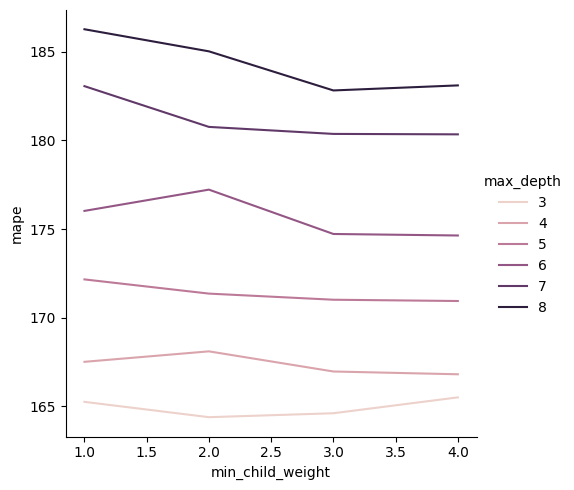

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

gs_results = grid_search.to_sklearn().cv_results_
max_depth_val = []
min_child_weight_val = []
for param_dict in gs_results["params"]:
    max_depth_val.append(param_dict["max_depth"])
    min_child_weight_val.append(param_dict["min_child_weight"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "max_depth":max_depth_val,
    "min_child_weight":min_child_weight_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="min_child_weight", y="mape", hue="max_depth", kind="line")

plt.show()

In [7]:
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error

result = grid_search.predict(test_df)
mape = mean_absolute_percentage_error(df=result,
                                        y_true_col_names="COUNT",
                                        y_pred_col_names="PREDICTED_COUNT")

result.select("COUNT", "PREDICTED_COUNT").show()
print(f"Mean absolute percentage error: {mape}")

The version of package 'xgboost' in the local environment is 1.7.6, which does not fit the criteria for the requirement 'xgboost==1.7.3'. Your UDF might not work when the package version is different between the server and your local environment.


-------------------------------
|"COUNT"  |"PREDICTED_COUNT"  |
-------------------------------
|1        |31                 |
|3        |25                 |
|36       |102                |
|94       |145                |
|106      |146                |
|93       |137                |
|37       |75                 |
|28       |86                 |
|39       |111                |
|17       |85                 |
-------------------------------

Mean absolute percentage error: 4.529012115642


c:\Users\Admin\anaconda3\envs\def_gui_3.8_env\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


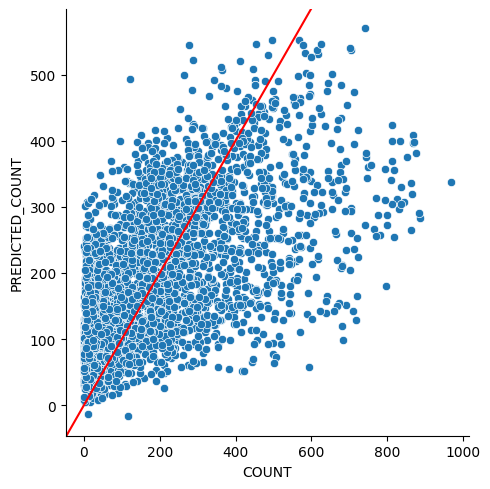

In [8]:
g = sns.relplot(data=result["COUNT", "PREDICTED_COUNT"].to_pandas().astype("float64"), x="COUNT", y="PREDICTED_COUNT", kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

### Registering The Model


In [9]:
from snowflake.ml.registry import model_registry
registry = model_registry.ModelRegistry(session=session, database_name="SNOWPARK_DEFINITVE_GUIDE", schema_name="My_SCHEMA", create_if_not_exists=True)

optimal_model = grid_search.to_sklearn().best_estimator_
optimal_max_depth = grid_search.to_sklearn().best_estimator_.max_depth
optimal_min_child_weight = grid_search.to_sklearn().best_estimator_.min_child_weight

optimal_mape = gs_results_df.loc[(gs_results_df['max_depth']==optimal_max_depth) &
                                 (gs_results_df['min_child_weight']==optimal_min_child_weight), 'mape'].values[0]

C:\Users\Admin\AppData\Local\Temp\ipykernel_21264\1983920624.py:2: DeprecationWarning: 
The `snowflake.ml.registry.model_registry.ModelRegistry` has been deprecated starting from version 1.2.0.
It will stay in the Private Preview phase. For future implementations, kindly utilize `snowflake.ml.registry.Registry`,
except when specifically required. The old model registry will be removed once all its primary functionalities are
fully integrated into the new registry.
        
  registry = model_registry.ModelRegistry(session=session, database_name="SNOWPARK_DEFINITVE_GUIDE", schema_name="My_SCHEMA", create_if_not_exists=True)
create_model_registry() is in private preview since 0.2.0. Do not use it in production. 


In [10]:
from snowflake.ml._internal.utils import identifier 


db = identifier._get_unescaped_name(session.get_current_database()) 
schema = identifier._get_unescaped_name(session.get_current_schema()) 

In [16]:
model_name = "bike_model_xg_boost"
model_version = 1
X = train_df.select(FEATURE_LIST).limit(100) 
registry.log_model(
    model_name=model_name,
    model_version=model_version,
    model=optimal_model,
    sample_input_data=X,
    options={"embed_local_ml_library": True, "relax": True})

registry.set_metric(model_name=model_name, model_version=model_version, metric_name="mean_abs_pct_err", metric_value=optimal_mape)

c:\Users\Admin\anaconda3\envs\def_gui_3.8_env\lib\site-packages\snowflake\ml\model\_packager\model_env\model_env.py:127: UserWarning: Package requirement anyio<4,>=3.5.0 specified, while version 4.2.0 is installed. Local version will be ignored to conform to package requirement.
  req_to_add = env_utils.get_local_installed_version_of_pip_package(req_to_check)
c:\Users\Admin\anaconda3\envs\def_gui_3.8_env\lib\site-packages\snowflake\ml\model\model_signature.py:69: UserWarning: The sample input has 100 rows, thus a truncation happened before inferring signature. This might cause inaccurate signature inference. If that happens, consider specifying signature manually.
  warnings.warn(


In [15]:
registry.delete_model("bike_model_xg_boost",1)

In [ ]:
#LIST MODELS IN THE REGISTRY

registry.list_models().to_pandas()

,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TYPE,URI,VERSION,ARTIFACT_IDS,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP
0,None,"{\n ""python"": ""3.8.16""\n}","""ACCOUNTADMIN""",2024-04-16 06:26:17.512000-07:00,e00fa52bfbf411ee89ba34f39a51dc3f,None,bike_model_xg_boost,None,None,xgboost,"sfc://SNOWPARK_DEFINITVE_GUIDE.""My_SCHEMA"".SNO...",1,None,None,"{\n ""mean_abs_pct_err"": 164.38951873779297\n}",None,2024-04-16 06:26:18.541000-07:00


### Model Registry Method
* Code snippets covers all vital model registry methods. Methods include as following
* Set, get & remove tags / Set model description
* Ways to access registry history & finding evaluation metric
* Loading model from registry

In [17]:
#set tag for your model

registry.set_tag(model_name=model_name, model_version=model_version, tag_name="usage", tag_value="experiment")
registry.list_models().to_pandas()[["NAME", "TAGS"]]

,NAME,TAGS
0,bike_model_xg_boost,"{\n ""usage"": ""experiment""\n}"


In [18]:
#removing tag

registry.remove_tag(model_name=model_name, model_version=model_version, tag_name="usage")
registry.list_models().to_pandas()[["NAME", "TAGS"]]

,NAME,TAGS
0,bike_model_xg_boost,{}


In [29]:
# #get tag value
# registry.set_tag(model_name=model_name, model_version=model_version, tag_name="usage", tag_value="experiment")
# print(registry.get_tag_value(model_name=model_name, model_version=model_version, tag_name="usage"))

# #get all tags
# print(registry.get_tags(model_name=model_name, model_version=model_version))

In [ ]:
#MODEL DESCRIPTION

registry.set_model_description(model_name=model_name, model_version=model_version, description="this is a test model")
print(registry.get_model_description(model_name=model_name, model_version=model_version))

this is a test model


In [ ]:

#REGISTRY HISTORY
registry.get_history().to_pandas()

,EVENT_TIMESTAMP,EVENT_ID,MODEL_ID,ROLE,OPERATION,ATTRIBUTE_NAME,VALUE[ATTRIBUTE_NAME]
0,2024-04-16 06:26:18.541000-07:00,e86d4bbbfbf411ee9fff34f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,REGISTRATION,"{\n ""CREATION_ENVIRONMENT_SPEC"": {\n ""pyth..."
1,2024-04-16 06:26:20.124000-07:00,e960f8a6fbf411ee8f6b34f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,METRICS,"{\n ""mean_abs_pct_err"": 164.38951873779297\n}"
2,2024-04-16 06:30:39.508000-07:00,83fc8b15fbf511ee919834f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
3,2024-04-16 06:31:06.149000-07:00,93dd338ffbf511ee8af334f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
4,2024-04-16 06:31:07.648000-07:00,94c24c92fbf511ee88f534f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,DESCRIPTION,"""this is a test model"""


In [ ]:

#MODEL HISTORY
registry.get_model_history(model_name=model_name, model_version=model_version).to_pandas()

,EVENT_TIMESTAMP,EVENT_ID,MODEL_ID,ROLE,OPERATION,ATTRIBUTE_NAME,VALUE[ATTRIBUTE_NAME]
0,2024-04-16 06:26:18.541000-07:00,e86d4bbbfbf411ee9fff34f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,REGISTRATION,"{\n ""CREATION_ENVIRONMENT_SPEC"": {\n ""pyth..."
1,2024-04-16 06:26:20.124000-07:00,e960f8a6fbf411ee8f6b34f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,METRICS,"{\n ""mean_abs_pct_err"": 164.38951873779297\n}"
2,2024-04-16 06:30:39.508000-07:00,83fc8b15fbf511ee919834f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
3,2024-04-16 06:31:06.149000-07:00,93dd338ffbf511ee8af334f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,TAGS,"{\n ""usage"": ""experiment""\n}"
4,2024-04-16 06:31:07.648000-07:00,94c24c92fbf511ee88f534f39a51dc3f,e00fa52bfbf411ee89ba34f39a51dc3f,"""ACCOUNTADMIN""",SET,DESCRIPTION,"""this is a test model"""


In [ ]:
#CHECK EVALUATION METRIC OF A MODEL

registry.get_metric_value(model_name=model_name, model_version=model_version, metric_name="mean_abs_pct_err")

164.38951873779297

In [20]:
#GET ALL METRICS STORED FOR A MODEL
registry.get_metrics(model_name=model_name, model_version=model_version)

{'mean_abs_pct_err': 164.38951873779297}

In [21]:
#load model from registry
xg_boost_model = registry.load_model(model_name=model_name, model_version=model_version)
xg_boost_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['int', 'int', 'int', 'float', 'float', 'float',
                            'int', 'int'],
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Deploying Model From Registry 

* Code snippet delineates steps involved in deployed model registered in model registry
* Also explains steps to predict using deployed models

In [22]:
#deploying a model from model registry
model_deployment_name = model_name + f"{model_version}" + "_UDF"

registry.deploy(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name,
                target_method="predict",
                permanent=True,
                options={"relax_version": True})

{'name': 'SNOWPARK_DEFINITVE_GUIDE."My_SCHEMA".bike_model_xg_boost2_UDF',
 'platform': <TargetPlatform.WAREHOUSE: 'warehouse'>,
 'target_method': 'predict',
 'signature': ModelSignature(
                     inputs=[
                         FeatureSpec(dtype=DataType.INT8, name='HOLIDAY'),
 		FeatureSpec(dtype=DataType.INT8, name='WORKINGDAY'),
 		FeatureSpec(dtype=DataType.INT8, name='HUMIDITY'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='TEMP'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='ATEMP'),
 		FeatureSpec(dtype=DataType.DOUBLE, name='WINDSPEED'),
 		FeatureSpec(dtype=DataType.INT8, name='SEASON'),
 		FeatureSpec(dtype=DataType.INT8, name='WEATHER')
                     ],
                     outputs=[
                         FeatureSpec(dtype=DataType.FLOAT, name='output_feature_0')
                     ]
                 ),
 'options': {'relax_version': True,
  'permanent_udf_stage_location': '@SNOWPARK_DEFINITVE_GUIDE."My_SCHEMA"._SYSTEM_REGISTRY_DEPLOYMENTS_STAGE/bike_m

In [24]:
#list all deployments for a model
registry.list_deployments(model_name, model_version).to_pandas()

,MODEL_NAME,MODEL_VERSION,DEPLOYMENT_NAME,CREATION_TIME,TARGET_METHOD,TARGET_PLATFORM,SIGNATURE,OPTIONS,STAGE_PATH,ROLE
0,bike_model_xg_boost,2,bike_model_xg_boost2_UDF,2024-04-16 06:46:54.558000-07:00,predict,warehouse,"{\n ""inputs"": [\n {\n ""name"": ""HOLIDA...","{\n ""permanent_udf_stage_location"": ""@SNOWPAR...","@SNOWPARK_DEFINITVE_GUIDE.""My_SCHEMA""._SYSTEM_...","""ACCOUNTADMIN"""


In [25]:
model_ref = model_registry.ModelReference(registry=registry, model_name=model_name, model_version=model_version)
result_sdf = model_ref.predict(deployment_name=model_deployment_name, data=test_df)
result_sdf.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SEASON"  |"HOLIDAY"  |"WORKINGDAY"  |"WEATHER"  |"TEMP"  |"ATEMP"  |"HUMIDITY"  |"WINDSPEED"       |"CASUAL"  |"REGISTERED"  |"COUNT"  |"HOUR"  |"MONTH"  |"WEEKDAY"  |"output_feature_0"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1         |0          |0             |1          |9.84    |14.395   |75          |12.7993954069447  |0         |1             |1        |4       |1        |6          |31.198890686035156  |
|1         |0          |0             |1          |8.2     |12.88    |86          |12.7993954069447  |1         |2             |3        |7       |1        |6          |24.61685562133789   |
|1         |0          |0             |1     

### Delete Model From Deployment & Registry

In [ ]:
#delete deployment
registry.delete_deployment(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name)
registry.list_deployments(model_name, model_version).to_pandas()

,MODEL_NAME,MODEL_VERSION,DEPLOYMENT_NAME,CREATION_TIME,TARGET_METHOD,TARGET_PLATFORM,SIGNATURE,OPTIONS,STAGE_PATH,ROLE


In [ ]:
#delete model from registry
registry.delete_model(model_name=model_name,
                model_version=model_version)
registry.list_models().to_pandas()

,CREATION_CONTEXT,CREATION_ENVIRONMENT_SPEC,CREATION_ROLE,CREATION_TIME,ID,INPUT_SPEC,NAME,OUTPUT_SPEC,RUNTIME_ENVIRONMENT_SPEC,TYPE,URI,VERSION,ARTIFACT_IDS,DESCRIPTION,METRICS,TAGS,REGISTRATION_TIMESTAMP
0,None,"{\n ""python"": ""3.10.12""\n}","""ACCOUNTADMIN""",2023-12-01 12:15:13.813000-08:00,50c21c92908611ee966a82be22e42801,None,bike_model_gradient_boost,None,None,sklearn,sfc://SNOWPARK.TUTORIAL.SNOWML_MODEL_50C21C929...,1,None,None,"{\n ""mean_abs_pct_err"": 68.89848373507952\n}",None,2023-12-01 12:15:15.062000-08:00
